# **Convolutional Neural Network to classify solar panels**

## **Step 1 : Building a dataloader for Kasmi et al. (2023)**

### The first part of this script builds a dataloader for  the Kasmi et al. (2023) dataset to train a CNN to detect solar panels 


### TO DO  ###

- [X] Créer un nouveau fichier .csv avec les annotations (uniquement pour les images google) et rentrer le lien dans le dataloader

- [ ] Copier le code sur Colab

- [ ] Comprendre plus en détail la définition de la classe CustomImageDataSet

In [78]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from PIL import Image

### 1) Label attribution ###

Nous allons faire de la classification binaire, on récupère donc les labels à partir des identifiants images et masques dans le jeu de données.

In [79]:
#Yanis
IGN_dataset = "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/ign/img"
annotations_file=pd.read_csv('C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/metadata.csv')

#Flo
#IGN_dataset = "/Users/lucius/Desktop/2A ENSAE/Projet Statapps/bdappv/ign/img"
#annotations_file=pd.read_csv('/Users/lucius/Desktop/2A ENSAE/Projet Statapps/bdappv/metadata.csv')

In [80]:
pd.set_option('display.max_columns', None)
annotations_file.head()

,idInstallation,identifiant,idInverter,nameInverter,countInverters,idArrays,nameArrays,countArrays,surface,azimuth,typeInstallation,tilt,kWp,departement,city,selfConsumption,isIntegrated,dateInstalled,controlled,IGNControlled,GoogleControlled
0,1,OSIBG1RDEDJ,593,SMA - Sunny Boy 2800,1,2120,Sanyo - HIP-215 NKHE1,14,22.0,-20.0,1,20,3010.0,31,Castanet-Tolosan,True,True,2007-09-01,True,True,False
1,10,VTIOIAEQJEC,601,SMA - Sunny Boy 4200 TL,1,2121,Sanyo - HIP-215 NKHE5,20,25.0,-40.0,1,30,4300.0,49,Saint-Barthélemy-d'Anjou,True,True,2007-09-01,True,True,False
2,1001,BWZEK3E9OJAOY,736,Sputnik - SOLARMAX 2000C,1,3110,Sunasol - SLMI140,15,15.0,180.0,1,25,2100.0,69,Décines-Charpieu,True,True,2007-12-01,True,False,False
3,1002,FEIKQ3EAGKXFB,256,Fronius - IG 30,1,2156,Schott - ASE-165-GT-FT/MC/170,18,23.0,10.0,1,20,3060.0,30,Rousson,True,True,2008-09-01,True,False,False
4,1003,NDXQX3EBUEZNO,591,SMA - Sunny Boy 2500,1,1188,Biohaus - Biosol 180 P 50/6+,16,23.0,180.0,1,45,2880.0,35,Andouillé-Neuville,True,True,2008-04-01,True,False,False


Le problème ici est que nous ne disposons pas de deux informations importantes : 
- A quelle dossier appartient quelle image? (IGN ou Google?)
- Comment splitter au hasard le training set du test set ?

In [81]:
annotations_file.shape

(28408, 21)

In [82]:
annotations_file['nameArrays'].value_counts()

Sanyo - HIP-214 NKHE5                                      965
Sanyo - HIP-210 NKHE1                                      674
Pas_dans_la_liste_panneaux - Pas_dans_la_liste_panneaux    389
SunPower - SPR-300-WHT-I                                   347
Schuco - MPE 200                                           292
                                                          ... 
Sunways - SM 215 M (215Wp)                                   1
SolarWorld - SW 196 vario poly                               1
Biohaus - Biosol 200M 50/6                                   1
Solon AG - M230 / 6+ (235W)                                  1
ALEO - aleo 200-6-XXL                                        1
Name: nameArrays, Length: 2551, dtype: int64

In [83]:
#création d'une fonction pour récupérer les noms d'un dossier

def f(path):
    dirs = os.listdir(path) #on définit le directory d'où on souhaite extraire le nom des fichiers
    return [file.replace('.png','') for file in dirs]

In [84]:
#Yanis
path_images_google = "C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/"
path_images_ign = 'C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/ign/img'
path_mask_google = 'C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/mask/'
path_mask_ign = 'C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/ign/mask/'

#Flo
#path_images_google = '/Users/lucius/Desktop/2A ENSAE/Projet Statapps/bdappv/google/img/'
#path_images_ign = '/Users/lucius/Desktop/2A ENSAE/Projet Statapps/bdappv/ign/img/'
#path_mask_google = '/Users/lucius/Desktop/2A ENSAE/Projet Statapps/bdappv/google/mask/'
#path_mask_ign = '/Users/lucius/Desktop/2A ENSAE/Projet Statapps/bdappv/ign/mask/'


# On récupère tous les noms des images Google et IGN

images = f(path_images_google) + f(path_images_ign)
im_g = f(path_images_google)

# On récupère ensuite tous les noms des images Google et IGN ayant des masques
#En effet, certaines images Google contiennent des panneaux mais n'ont pas de masque 
#alors que leur équivalent IGN possède un masque, on doit donc leur attribuer le label '1' pour les classifier ensuite

im_mask_google = f(path_mask_google)
im_mask_ign = f(path_mask_ign)


#Google

#IGN

In [85]:
im = pd.DataFrame (images, columns = ['identifiant'])
im_mask_google = pd.DataFrame (im_mask_google, columns = ['identifiant'])
im_g = pd.DataFrame (im_g, columns = ['identifiant'])
im_mask_ign = pd.DataFrame (im_mask_ign, columns = ['identifiant'])

#On label '1' toutes les images comportant un masque et 0 sinon
im['Label'] = im['identifiant'].isin(im_mask_ign['identifiant'].append(im_mask_google['identifiant'])).astype(int)

im['Label'].value_counts() #on vérifie bien qu'on a des valeurs cohérentes 

#On label '1' toutes les images Google et '0' sinon
im['L_Google'] = im['identifiant'].isin(im_g['identifiant']).astype(int)

C:\Users\yanis\AppData\Local\Temp\ipykernel_89740\3565360278.py:7: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  im['Label'] = im['identifiant'].isin(im_mask_ign['identifiant'].append(im_mask_google['identifiant'])).astype(int)


In [86]:
im['L_Google'].value_counts()  

1    46132
Name: L_Google, dtype: int64

In [87]:
#On ne garde que les images Google pour le moment

im = im.drop(im[im.L_Google<1].index) #on vire les images IGN sans équivalent Google

im['L_Google'].value_counts()  



1    46132
Name: L_Google, dtype: int64

In [88]:
#On sait que beaucoup d'images Google ont leur équivalent IGN (échelle différente) 
#on ne garde donc qu'un seul nom (comme sur le fichier metadata)

im = im.drop_duplicates() #On vire les images IGN qui avaient un équivalent Google
len(im) == im['identifiant'].nunique()


True

In [89]:
df = pd.merge(annotations_file, im, how="outer", on=["identifiant"]) #cette partie de script ne récupère que les noms déjà présents dans la base

## **Préparation du dataloader**

Pour cette partie, nous avons principalement repris la documentation PyTorch sur la programmation des DataLoaders, que l'on peut retrouver ici : https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

In [90]:
#On ne garde que l'identifiant et les labels
df= df[['identifiant', 'Label']]
df.head()
df['identifiant'] = df['identifiant'].astype(str) + '.png' #on rajoute les extensions pour que le dataloader récupère les fichiers
print(df)

              identifiant  Label
0         OSIBG1RDEDJ.png      1
1         VTIOIAEQJEC.png      1
2       BWZEK3E9OJAOY.png      1
3       FEIKQ3EAGKXFB.png      1
4       NDXQX3EBUEZNO.png      1
...                   ...    ...
28802  ZSJUF9D86VXWNP.png      0
28803  ZTWLYA184ENGAS.png      0
28804  ZWQWEA126PAFZU.png      0
28805  ZYQEUA171IQHCJ.png      0
28806  ZZJOTA1ABCOIYW.png      0

[28807 rows x 2 columns]


Ici on doit déjà préparer la différence entre dataset d'entrainement et dataset de test pour faire deux instanciations différentes de la classe dataset, par conséquent on va diviser de façon équilibrée le dataset en training et test datasets.

In [91]:
#On sépare le dataset en un training dataset et un test dataset avec sci-kit learn
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=0)

train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)



On va maintenant créer la classe qui va nous permettre d'importer facilement les images pour entrainer notre réseau de neurones.

In [100]:
#Codage du dataloader à la main

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        #image = read_image(img_path)
        image = Image.open(img_path).convert('RGB') #Yanis
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
            
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    ...

Dans notre cas, on réimporte les données des panneaux solaires.


In [101]:
#Yanis
training_data="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/train_data.csv"
test_data="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/test_data.csv"

#Flo
#annot = "/Users/lucius/Desktop/label_google.csv"
#training_data = "/Users/lucius/Desktop/train_data.csv"
#test_data = "/Users/lucius/Desktop/test_data.csv"

#dataset = CustomImageDataset(annot,path_images_google)

training_data = CustomImageDataset(training_data,path_images_google , transform=ToTensor())
test_data = CustomImageDataset(test_data,path_images_google, transform=ToTensor())
# Create a data loader to iterate over the dataset
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Important: ToTensor converts a PIL image or NumPy ndarray into a FloatTensor. and scales the image’s pixel intensity values in the range [0., 1.]

On applique la transformation car elle permet d'avoir des tenseurs qui utilisent le float32 dtype et non le uint8 dtype comme à l'origine. Sans quoi, on a l'erreur: "RuntimeError: Input type (unsigned char) and bias type (float) should be the same" dans la cellule où on run le CNN.

Feature batch shape: torch.Size([64, 3, 400, 400])


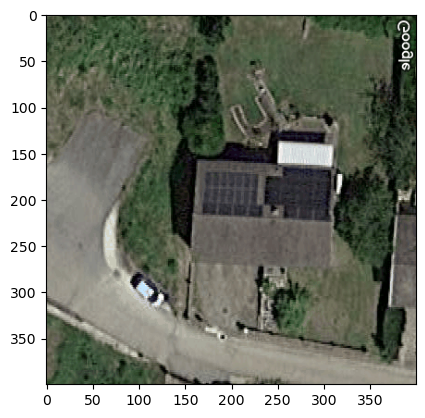

Label: 1


In [109]:
# Display image and label.

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
#print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img.T)
plt.show()
print(f"Label: {label}")

In [110]:
train_features[0]

tensor([[[0.3451, 0.4078, 0.3608,  ..., 0.2275, 0.2235, 0.2235],
         [0.3608, 0.4078, 0.4235,  ..., 0.1961, 0.2235, 0.1961],
         [0.3608, 0.4078, 0.4078,  ..., 0.1961, 0.1569, 0.1569],
         ...,
         [0.0941, 0.0157, 0.0314,  ..., 0.6431, 0.6275, 0.6275],
         [0.0314, 0.0745, 0.0745,  ..., 0.6275, 0.6275, 0.6118],
         [0.2039, 0.0941, 0.0941,  ..., 0.6275, 0.6118, 0.6000]],

        [[0.4078, 0.4235, 0.4157,  ..., 0.3216, 0.3176, 0.3176],
         [0.4157, 0.4706, 0.4392,  ..., 0.2902, 0.3176, 0.2902],
         [0.4157, 0.4706, 0.4706,  ..., 0.2588, 0.2510, 0.2510],
         ...,
         [0.1569, 0.0471, 0.0941,  ..., 0.6275, 0.6118, 0.6000],
         [0.0941, 0.1059, 0.1059,  ..., 0.6118, 0.6000, 0.5961],
         [0.2510, 0.1569, 0.1569,  ..., 0.6000, 0.5961, 0.5804]],

        [[0.2980, 0.3451, 0.3216,  ..., 0.2235, 0.2039, 0.2039],
         [0.3216, 0.3451, 0.3765,  ..., 0.1725, 0.2039, 0.1725],
         [0.3216, 0.3451, 0.3451,  ..., 0.1608, 0.1373, 0.

In [111]:
train_features[0].size()

torch.Size([3, 400, 400])

Le tenseur est bien au format RGB.

# CNN LeNet5

In [95]:
# librairies
import numpy as np
import random
from sklearn import preprocessing
# import mnist # package à installer conda install -c conda-forge mnist
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

On peut voir que le modèle atteint de bonnes performances (90% environ). Maintenant, on va définir un CNN et l'entrainer lui aussi sur MNIST.

### Définition d'un réseau convolutif

L'exemple ci-dessus a permis d'avoir un premier exemple du fonctionnement de Pytorch. Dans la suite, vous allez utiliser ce modèle pour implémenter vous-même un LeNet5. Jusqu'à présent, nous avons vu un type de couche : la couche complètement connectée ou <i> fully connected </i>. Ces couches sont notées $Fx$, où $x$ correspond à l'indice de la couche. 
Avec les réseaux convolutifs, on peut introduire deux nouveaux types de couches : 
* Les couches convolutives (notées $Cx$)
* Les couches de pooling ou de subsampling (notées $Sx$)

Ces couches sont définies dans le livre [DeepMaths](https://exo7math.github.io/deepmath-exo7/livre-deepmath.pdf) (p. 236 et suivantes pour les couches convolutives, p. 207 pour le subsampling).


#### Les couches convolutives

Pour implémenter une couche convolutive avec Pytorch, on utilise la fonction `Conv2D` du module `nn`. Les arguments de cette couche sont le nombre de canaux en entrée, `in_channels`, le nombre de canaux en sortie `out_channels`, la taille du noyaux `kernel_size` et la taille du stride, `stride`. Le `stride` est le pas (en pixels) appliqué au noyau. Pour un stride de 1, alors le noyau se déplace d'un pixel vers la droite, puis une fois la ligne terminée d'un pixel vers le bas. Un dernier paramètre est le `padding` qui correspond à un "agrandissement" artificiel de l'image lorsque le noyau passe sur les pixels au bord de l'image. 

On parle parfois de <i> feature map </i> pour désigner un ensemble d'unités de la couche convolutive pour lesquelles les poids sont identiques. Les features maps correspondent aux sorties de la couche convolutive. Dans l'exemple p.236 de DeepMaths, les features maps sont les filtres $M_1,\dots M_32$. 

#### Les couches de subsampling

Les couches de subsampling ou de pooling permettent de réduire la dimension des entrées. Le principe est de définir un noyau sur lequel on applique une opération de pooling (généralement moyenne ou max).

#### Les couches d'aplatissement

Ces couches consistent à reformater la sortie d'une couche convolutive (par exemple un tenseur $10\times10\times6$) en un vecteur de dimension 600. On utilise la fonction `nn.Flatten` pour faire cet aplatissement. 

#### L'architecture à implémenter

Vous pouvez retrouver cette architecture sur la figure 2 du papier accessible [au lien suivant](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf). Dans notre implémentation, on se propose de découper le modèle en deux parties: un <i> feature extractor </i> et un <i> classifier </i> classique. On définit donc deux méthodes, `self.feature_extractor` et `self.classifier`. Les paramètres pour le feature extractor sont les suivants:

* Une couche $C_1$ qui consiste en la définition de 6 features maps (argument `out_channels`). Le noyau a une taille de 5, le stride est de 1 et le padding de 2. La couche se termine par une nonlinéarité `tanh`
* Une couche $S_2$ est une couche de pooling (voir [ici](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html) pour la fonction à utiliser). Le kernel est de 2 et le stride de 2.
* Une couche $C_3$ est une couche qui prend les 6 features maps de $S_2$ en entrée et renvoie 16 features maps. Le noyau a une taille de 5, le stride est de 1. Il n'y a pas de padding.  La couche se termine par une nonlinéarité `tanh`
* Une couche $S_4$ est à nouveau une couche de pooling.
* Une couche $C_5$ est une dernière couche qui renvoie 120 feature maps. Le noyeau de cette couche est de taille 5. La couche se termine par une nonlinéarité `tanh`

A la suite de ces couches convolutives, on applique un réseau à deux couches classique. La dimension d'entrée est 120 (contre 28*28 pour les données source). La dimension de la couche cachée est 84 et la dimension de sortie 10. 

<i> Remarque </i> 

Vous pourrez trouver certaines implémentations avec une taille d'input valant 32*32 au lieu de 28*28. Dans ce cas, il n'y a pas de padding appliqué. L'agrandissement de la taille de l'input permet d'avoir des features maps d'une taille 28*28 (ce que permet de manière équivalente le padding de 2).

#### Format des données en sortie de couches convolutives

Le format des tenseurs en sortie de couches convolutives est du type \[N,C,H,W\]:
* N: nombre de batchs ie, de sous-échantillons
* C: image channels (si RGB, C=3)
* H: hauteur
* W: largeur

#### Remplir les paramètres du réseau


##### Calcul des dimensions:

Soit une image de dimensions $L \times H \times C$. A la sortie d'une couche de convolution comportant $K$ filtres, la dimension de l'image est:

\begin{equation}

    (\frac{L-kernelsize+2 \times padding}{stride} +1) \times (\frac{L-kernelsize+2 \times padding}{stride} +1) \times K

\end{equation}

##### in_channels/out_channels:

in_channels couche n+1 = out_channels couche n

In [105]:
#Dimension des images: 400*400
#n_classes = dimension de l'espace de Y (2 comme on est en classification binaire)
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()

        # Première partie du modèle, qui correspond aux couches convolutionnelles.
        #Remarque: padding: ajoute les 0 artificiels sur les bords du tenseur
        #padding = 1 400*400 -> 402*402
        #padding = 2 400*400 -> 404*404

        self.feature_extractor = nn.Sequential(
            ####Première couche de convolution####

            # 3 composantes par pixel (si noir et blanc: 1): in_channels = 3
            # 6 filtres: out_channels=6
            # Dimension du motif = 5
            # Stride (pas) = 1
            # Padding = 2
            # Activation tanh
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding = 2),
            nn.Tanh(),

            #Première couche de pooling
            nn.AvgPool2d(kernel_size=2, stride=2),

            #Résumé

            #Input: 400*400*3
            #Après padding: 404*404*3
            #Après convolution: 400*400*6 (400=404-5+1)
            #Après pooling: 200*200*6

        ####Deuxième couche de convolution####

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),

            #Deuxième couche de pooling

            nn.AvgPool2d(kernel_size=2, stride=2),

            #Résumé

            #Input: 200*200*6
            #Après convolution: 196*196*16 (196=200-5+1)
            #Après pooling: 98*98*16
        
        ####Troisième couche de convolution####

            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),

            #Input: 98*98*16
            #Après convolution: 94*94*120 (94=98-5+1)

            
            nn.Flatten(start_dim = 1, end_dim = -1), # on applique un applatissement à la dernière couche pour renvoyer un vecteur de taille 94*94*120=1060320 au classifieur
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=1060320, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        logits = self.classifier(x)
        # probs = F.softmax(logits, dim=1)
        return logits# , probs

### torch.size()

torch.Size([2, 3, 2]): tenseur de profondeur 2, comportant 3 lignes et 2 colonnes

In [106]:
# initialize the model, the loss and the criterion

n_classes = 2
model = LeNet5(n_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr = 0.01)

print(model)

# number of epochs to train the model
n_epochs = 3# initialize tracker for minimum validation loss
valid_loss_min = np.Inf  # set initial "min" to infinity

# lists to be plotted at the end of the training

train_losses, val_losses = [], []

for epoch in range(n_epochs):

    # monitor losses
    train_loss = 0
    valid_loss = 0

        
    ###################
    # train the model #
    ###################
    model.train() # prep model for training

    for data,label in train_dataloader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item() * data.size(0)
        
        
    ######################    
    # validate the model #
    ######################
    model.eval()  # prep model for evaluation
    
    for data,label in test_dataloader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output,label)
        # update running validation loss 
        valid_loss = loss.item() * data.size(0)

    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.sampler) 
    valid_loss = valid_loss / len(test_dataloader.sampler)

    train_losses.append(train_loss)
    val_losses.append(valid_loss) 

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        ))

# plot of the losses
plt.plot([*range(len(train_losses))], train_losses / np.sum(train_losses), label = "Train")
plt.plot([*range(len(train_losses))], val_losses / np.sum(val_losses), label = "Val")
plt.xlabel('Training epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


LeNet5(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (6): Conv2d(16, 120, kernel_size=(5, 5), stride=(1, 1))
    (7): Tanh()
    (8): Flatten(start_dim=1, end_dim=-1)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1060320, out_features=84, bias=True)
    (1): Tanh()
    (2): Linear(in_features=84, out_features=2, bias=True)
  )
)


KeyboardInterrupt: 

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
model.eval() # prep model for evaluation

for data, target in test_dataloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_dataloader.sampler)

print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of class %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        #print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))
        print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

print("""
Overall accuracy {:0.2f} %
""".format(np.sum(class_correct) / np.sum(class_total) * 100))

# obtain one batch of test images
dataiter = iter(test_dataloader)
images, labels = next(dataiter)# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# CNN ResNet 18

Important: par défaut, le ResNet 18 fonctionne pour des images 224*224. Comme on a du 400*400, il faut le modifier (cf. le dernier lien en dessous)

Architecture: https://debuggercafe.com/implementing-resnet18-in-pytorch-from-scratch/

Expications du LeNet5:

https://github.com/lychengrex/LeNet-5-Implementation-Using-Pytorch/blob/master/LeNet-5%20Implementation%20Using%20Pytorch.ipynb

https://learn.microsoft.com/fr-fr/windows/ai/windows-ml/tutorials/pytorch-train-model

https://medium.datadriveninvestor.com/architecture-implementation-of-lenet-from-scratch-in-pytorch-709cc38c00a9

(Ca a l'air bien): modification du ResNet 18 pour pouvoir prendre en entrée des images autre que 224*224

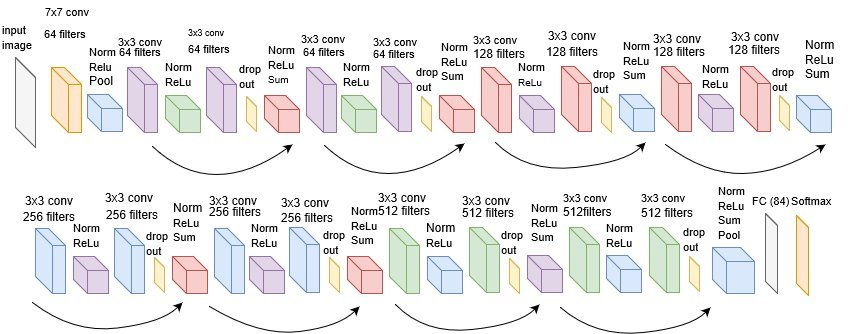

A compléter:

In [ ]:
#Dimension des images: 400*400
#n_classes = dimension de l'espace de Y (2 comme on est en classification binaire)
class ResNet18(nn.Module):

    def __init__(self, n_classes):
        super(ResNet18, self).__init__()

        self.feature_extractor = nn.Sequential(
            ####Première couche de convolution####

            # 1 composante par pixel (pas de couleur sinon 3): in_channels = 1
            # 6 filtres: out_channels=6
            # Dimension du motif = 5
            # Stride (pas) = 1
            # Padding = 2
            # Activation tanh
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding = 2),
            nn.Tanh(),

            #Première couche de pooling
            #kernel_size=2
            #stride=2
            nn.AvgPool2d(kernel_size=2, stride=2),

            #Résumé

            #Input: 400*400*1
            #Après padding: 404*404*1
            #Après convolution: 400*400*6 (400=404-5+1)
            #Après pooling: 200*200*6

        ####Deuxième couche de convolution####

            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),

            #Deuxième couche de pooling
            #kernel_size=2
            #stride=2

            nn.AvgPool2d(kernel_size=2, stride=2),

            #Résumé

            #Input: 200*200*6
            #Après padding: 200*200*6 (pas de padding)
            #Après convolution: 196*196*16 (196=200-5+1)
            #Après pooling: 98*98*16
        
        ####Troisième couche de convolution####

            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),

            #Input: 98*98*16
            #Après convolution: 94*94*120 (94=98-5+1)

            
            nn.Flatten(start_dim = 1, end_dim = -1), # on applique un applatissement à la dernière couche pour renvoyer un vecteur de taille 94*94*120=1060320 au classifieur
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=1060320, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )

    def forward(self, x):
        x = self.feature_extractor(x)
        logits = self.classifier(x)
        # probs = F.softmax(logits, dim=1)
        return logits# , probs